In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
# %matplotlib notebook

# https://stackoverflow.com/questions/28320247/density-plot-on-a-sphere-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import sys
import chart_studio.plotly as py
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter

sys.path.append('../fibermetric/')
import sta_validate
import histology
import apsym_kmeans

# make figures for 2D experiments

## Experiment 1: 2D single orienation

In [3]:
# concatenate all the pandas dataframes corresponding to phantoms with a single angle
# sta_out = '../outputs/sta_validate_outputs/sta_2d_out/'
sta_out = '../outputs/sta_validate_outputs/sta_2d_iso-blur_out/'
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='.'] # only get the files with one line angle
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

print(len(files))
print(derivative_sigmas)
print(tensor_sigmas)
print(errors_df.iloc[0])
errors_df.iloc[0]

2400
[0.15       0.41111111 0.67222222 0.93333333 1.19444444 1.45555556
 1.71666667 1.97777778 2.23888889 2.5       ]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]
derivative_sigma                  0.15
tensor_sigma                       0.0
AI                                 8.0
period                            13.0
width                              1.0
angles              0.2221328138901874
error                        10.444445
Name: 0, dtype: object


derivative_sigma                  0.15
tensor_sigma                       0.0
AI                                 8.0
period                            13.0
width                              1.0
angles              0.2221328138901874
error                        10.444445
Name: 0, dtype: object

## Figure 1: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [4]:
# average errors_df over all angles and periods
errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['error'].mean().reset_index()
errors_df_grouped.iloc[79:85]

errors = errors_df_grouped['error'].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

Text(0.5, 0.98, '2D Single Angle')

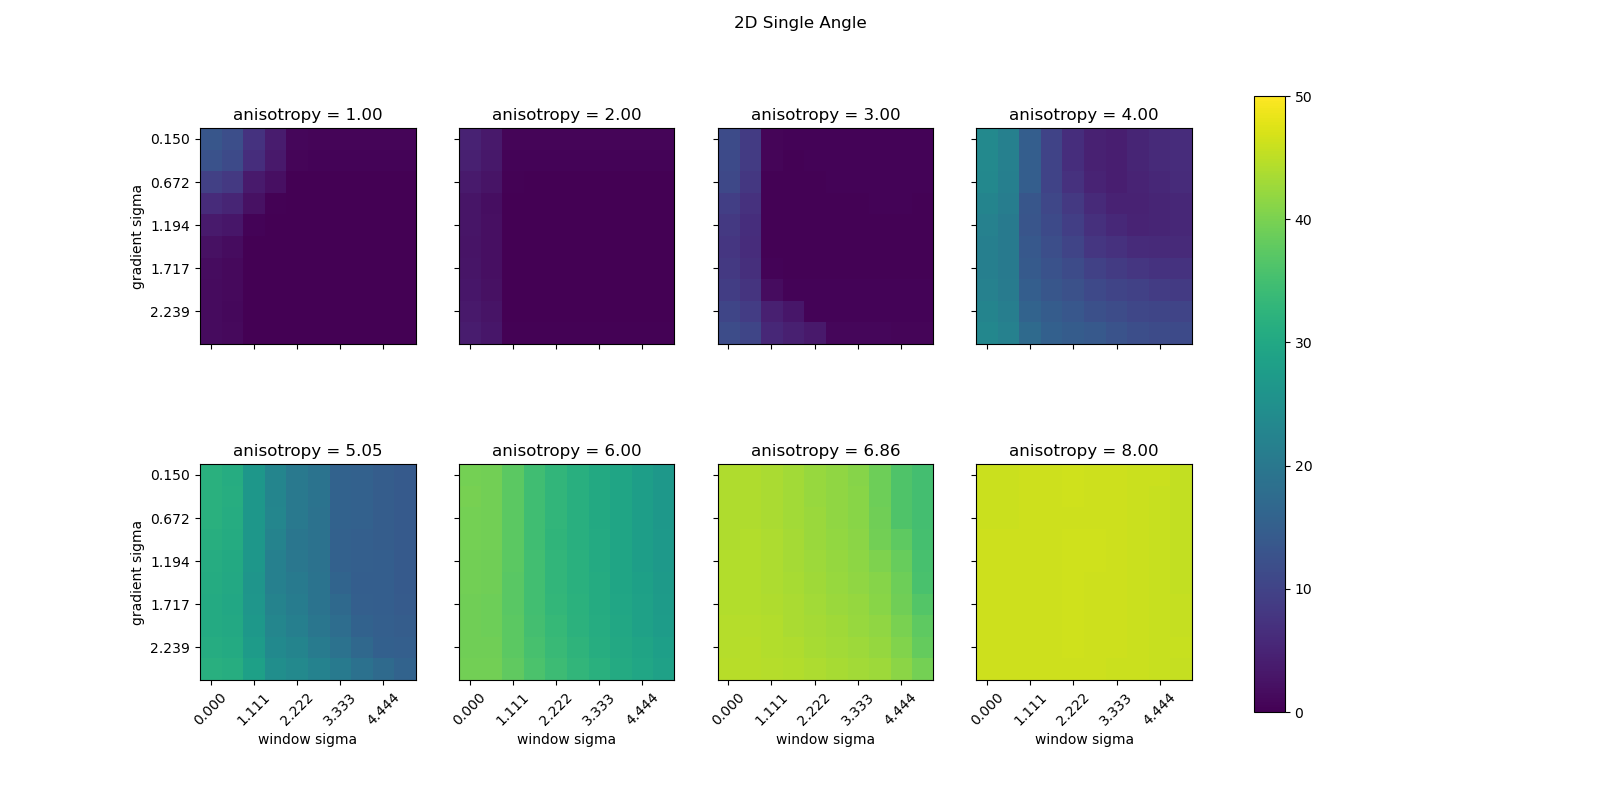

In [5]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'anisotropy = {AI[i]:.2f}')
    # set x tick labels
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    # set tick locations
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel('gradient sigma')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel('window sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
# set figure title
fig.suptitle('2D Single Angle')

## figure 2: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [6]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')


## figure 3: The best sigma 1 and sigma 2 vs anisotropy ratio.

In [7]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

Text(0.5, 0, 'anisotropy ratio')

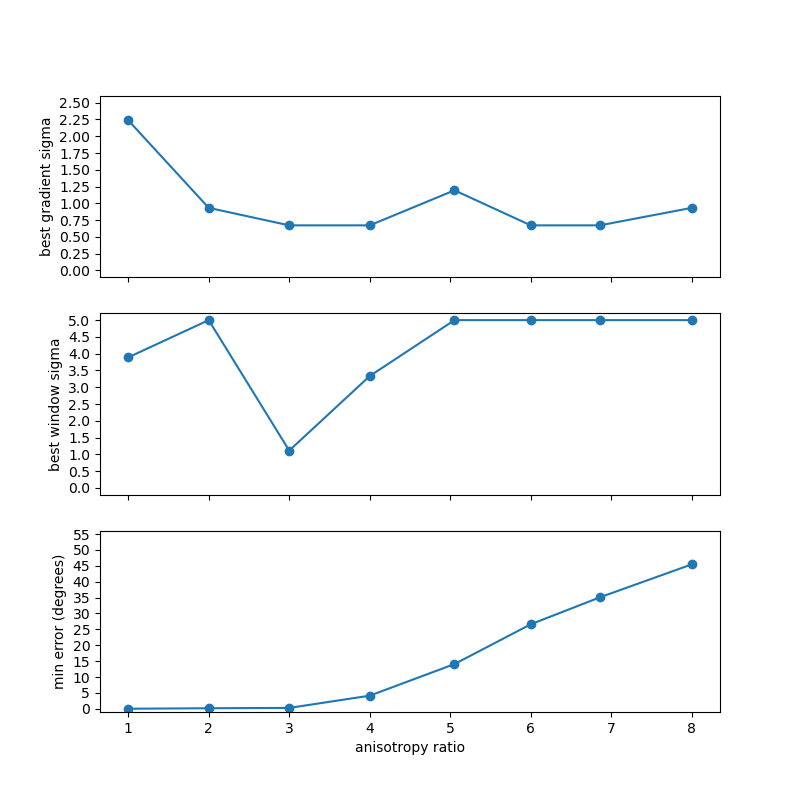

In [8]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(8,8), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,2.75,0.25))
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
axs[1].set_yticks(np.arange(0.0,5.5,0.5))
axs[0].set_ylabel('best gradient sigma')
axs[1].set_ylabel('best window sigma')
axs[2].plot(AI, errors_min, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,60,5))
axs[2].set_ylabel('min error (degrees)')
axs[2].set_xlabel('anisotropy ratio')
# fig.suptitle('2D Single Angle')


## Experiment 2: 2D two angles

In [9]:
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='-'] # only get the files with two line angles
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())
print(len(files))

2400


In [10]:
# average errors_df over all angles and periods
errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['error'].mean().reset_index()
errors_df_grouped.iloc[79:85]

errors = errors_df_grouped['error'].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

Text(0.5, 0.98, '2D Two Angles')

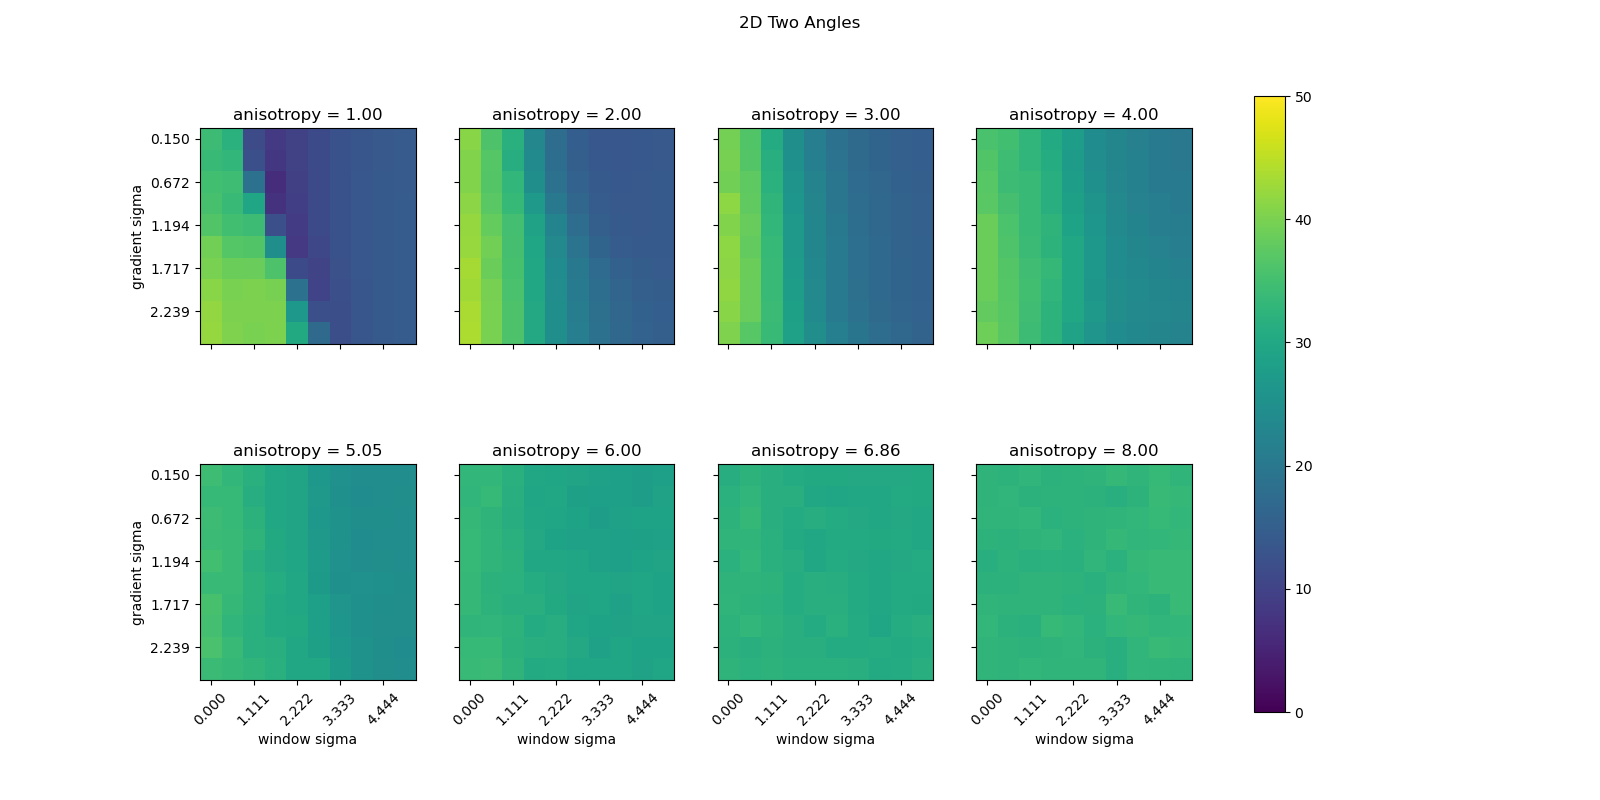

In [11]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'anisotropy = {AI[i]:.2f}')
    # set x tick labels
    # set the locations of the xticks and yticks
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel('gradient sigma')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel('window sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
fig.suptitle('2D Two Angles')


In [12]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

In [13]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
# fig, axs = plt.subplots(2, sharex=True)
# axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
# axs[0].set_ylim(-0.1,2.6)
# axs[0].set_yticks(np.arange(0.0,2.75,0.25))
# axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
# axs[1].set_ylim(-0.2,5.2)
# axs[1].set_yticks(np.arange(0.0,5.5,0.5))
# axs[0].set_ylabel('best gradient sigma')
# axs[1].set_ylabel('best window sigma')
# axs[1].set_xlabel('anisotropy ratio')

Text(0.5, 0, 'anisotropy ratio')

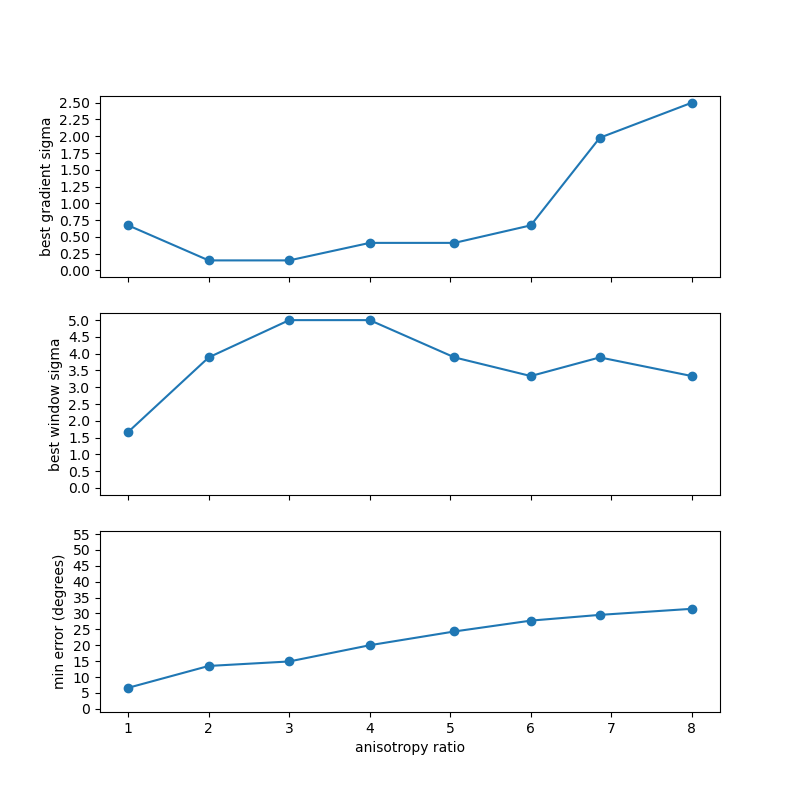

In [14]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(8,8), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,2.75,0.25))
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
axs[1].set_yticks(np.arange(0.0,5.5,0.5))
axs[0].set_ylabel('best gradient sigma')
axs[1].set_ylabel('best window sigma')
axs[2].plot(AI, errors_min, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,60,5))
axs[2].set_ylabel('min error (degrees)')
axs[2].set_xlabel('anisotropy ratio')
# fig.suptitle('2D Two Angles')

# 3D experiments

## Experiment 4: single orientation

In [15]:
# concatenate all the pandas dataframes corresponding to phantoms with a single angle
# sta_out = '../outputs/sta_validate_outputs/sta_3d_out_v3/'
# sta_out = '../outputs/sta_validate_outputs/sta_3d_iso-blur_out_v3/'
sta_out = '../outputs/sta_validate_outputs/sta_3d_out_v5/'

files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='_'] # only get the files with one line angle
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

print(len(files))
print(derivative_sigmas)
print(tensor_sigmas)
errors_df.iloc[0]

2400
[0.15       0.41111111 0.67222222 0.93333333 1.19444444 1.45555556
 1.71666667 1.97777778 2.23888889 2.5       ]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]


derivative_sigma                                       0.15
tensor_sigma                                            0.0
AI                                                      8.0
period                                                 10.0
width                                                   1.0
angles              [1.1112644169182018, 3.090722384277176]
error                                               72.6016
Name: 0, dtype: object

## figure 7: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [16]:
# average errors_df over all angles and periods
errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['error'].mean().reset_index()
errors_df_grouped.iloc[79:85]

,derivative_sigma,tensor_sigma,AI,error
79,0.150000,5.0,8.000000,35.060850
80,0.411111,0.0,1.000000,34.163956
81,0.411111,0.0,2.000000,34.748191
82,0.411111,0.0,3.000000,38.326570
83,0.411111,0.0,4.000000,41.316842
84,0.411111,0.0,5.142857,43.084554


In [17]:
errors = errors_df_grouped['error'].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

Text(0.5, 0.98, '3D Single Angle')

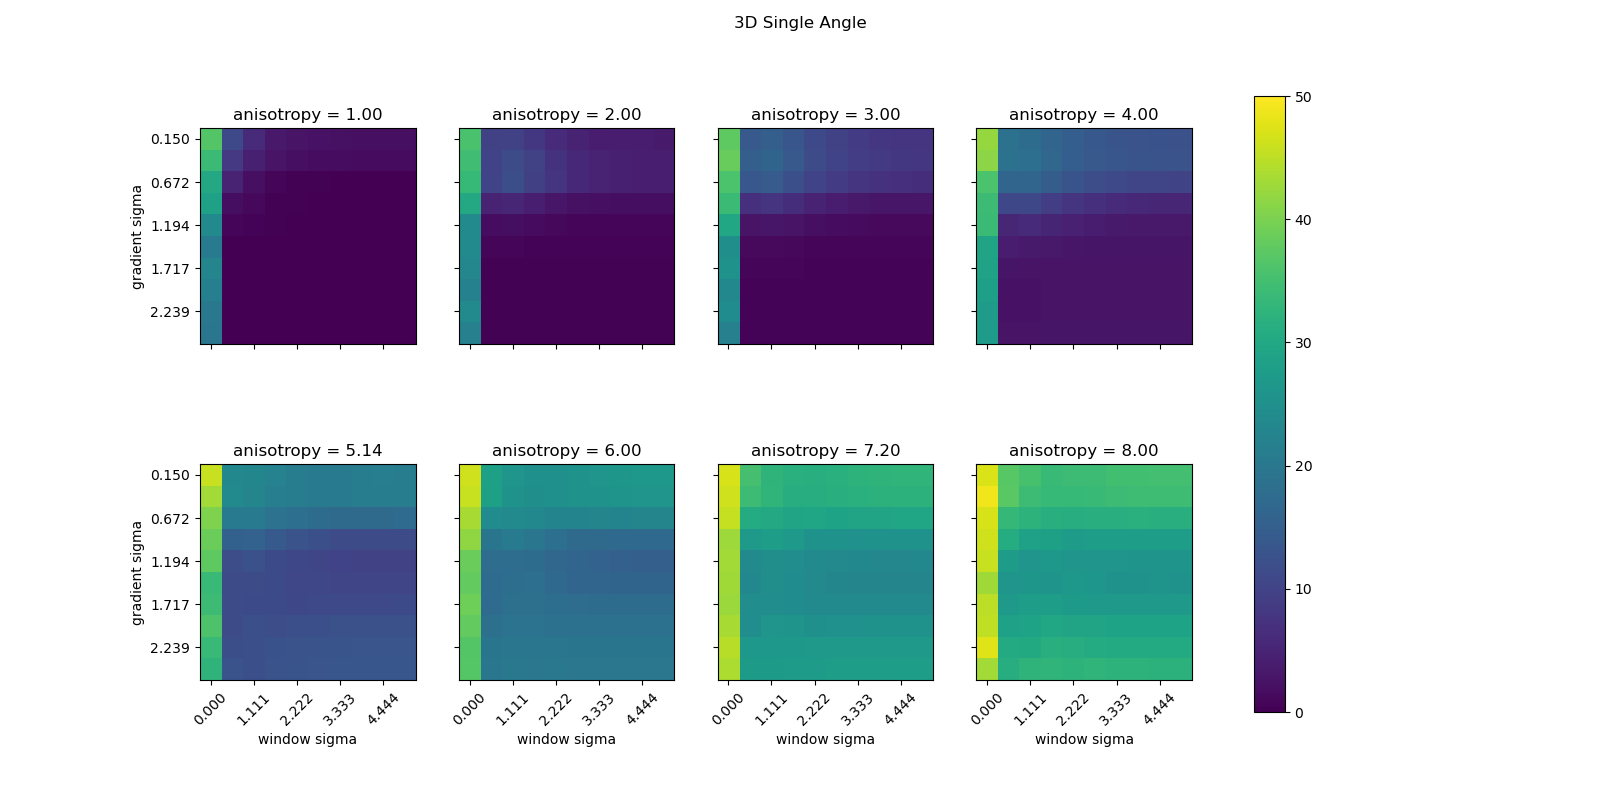

In [18]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'anisotropy = {AI[i]:.2f}')
    # set x tick labels
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    # set tick locations
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel('gradient sigma')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel('window sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
# set figure title
fig.suptitle('3D Single Angle')

## figure 8: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [19]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

## figure 9: The best sigma 1 and sigma 2 vs anisotropy ratio.

In [20]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

Text(0.5, 0, 'anisotropy ratio')

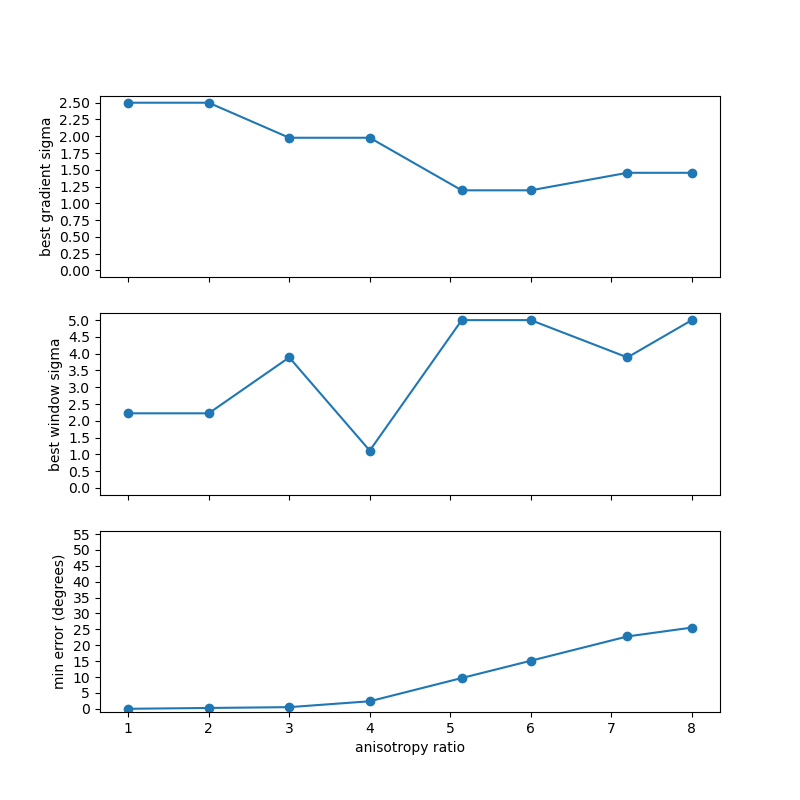

In [21]:
# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(8,8), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,2.75,0.25))
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
axs[1].set_yticks(np.arange(0.0,5.5,0.5))
axs[0].set_ylabel('best gradient sigma')
axs[1].set_ylabel('best window sigma')
axs[2].plot(AI, errors_min, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,60,5))
axs[2].set_ylabel('min error (degrees)')
axs[2].set_xlabel('anisotropy ratio')



## Error vs angle

PearsonRResult(statistic=0.02401796864185014, pvalue=0.8125061052032964)


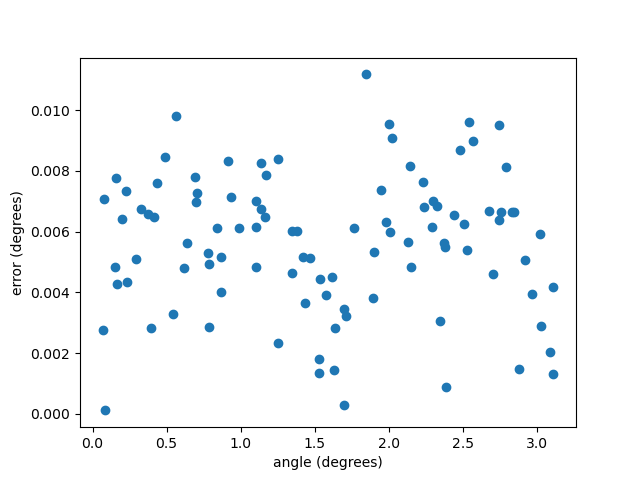

In [22]:
import scipy


df = errors_df.query(f'derivative_sigma=={derivative_sigmas[9]} and tensor_sigma=={tensor_sigmas[4]} and AI==1.0 and period==10.0')

errors = df['error']
angles = df['angles']
angles = np.array([np.array(a) for a in angles])
plt.figure()
plt.scatter(angles[:,1], errors)
plt.xlabel('angle (degrees)')
plt.ylabel('error (degrees)')
correlation = scipy.stats.pearsonr(angles[:,0], errors)
print(correlation)

## Experiment 5: 3D two angles

In [23]:
files = os.listdir(sta_out)
files = [f for f in files if f.split('theta-')[1][4]=='-'] # only get the files with two line angles
errors_df = pickle.load(open(sta_out+files[0], 'rb'))
for f in files[1:]:
    errors_df = pd.concat([errors_df, pickle.load(open(sta_out+f, 'rb'))], axis=0)
derivative_sigmas = errors_df['derivative_sigma'].unique()
tensor_sigmas = errors_df['tensor_sigma'].unique()
AI = np.sort(errors_df['AI'].unique())

## figure 10: heatmap of errors for sigma 1 vs sigma 2 at each anisotropy

In [24]:
errors_df_grouped = errors_df.groupby(['derivative_sigma', 'tensor_sigma', 'AI'])['error'].mean().reset_index()
errors = errors_df_grouped['error'].values.reshape((len(derivative_sigmas), len(tensor_sigmas), len(AI)))

In [25]:
tensor_sigmas

array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])

Text(0.5, 0.98, '3D Two Angles')

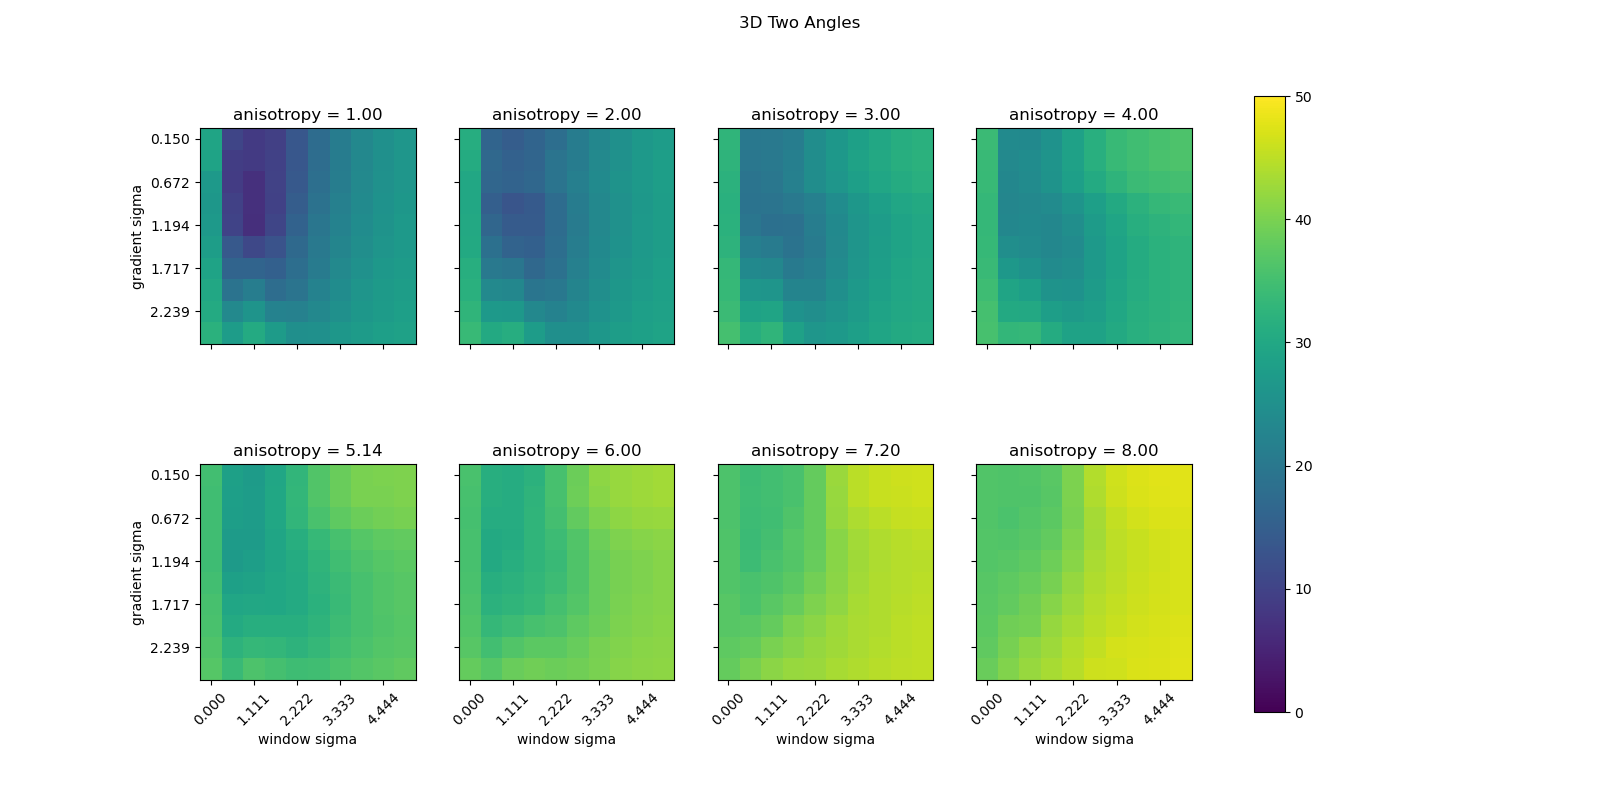

In [26]:
rows = 2
cols = 4
vm = 50
fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
for i in range(len(AI)):
    error = errors[...,i]
    axs[i//cols,i%cols].imshow(error, vmin=0, vmax=vm)
    axs[i//cols,i%cols].set_title(f'anisotropy = {AI[i]:.2f}')
    # set x tick labels
    # set the locations of the xticks and yticks
    xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
    yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
    axs[i//cols, i%cols].set_xticks(np.arange(len(tensor_sigmas))[::2])
    axs[i//cols, i%cols].set_yticks(np.arange(len(derivative_sigmas))[::2])
    axs[i//cols, i%cols].set_xticklabels(xticklabels[::2], rotation=45)
    axs[i//cols, i%cols].set_yticklabels(yticklabels[::2])
    if i%cols==0:
        axs[i//cols,i%cols].set_ylabel('gradient sigma')
    if i > cols * (rows-1) - 1:
        axs[i//cols,i%cols].set_xlabel('window sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
fig.suptitle('3D Two Angles')


## figure 11: The smallest average single-angle error, optimized over sigmas, versus anisotropy ratio.

In [27]:
# min the error array over the first two axes
errors_min = np.min(errors, axis=(0,1))
# plot the min error for each anisotropy ratio
# plt.figure()
# # set figure title
# plt.plot(AI, errors_min, marker='o')
# plt.ylim(-1,56)
# plt.yticks(np.arange(0,60,5))
# plt.xlabel('anisotropy ratio')
# plt.ylabel('min error (degrees)')

## figure 12: The best sigma 1 and sigma 2 vs anisotropy ratio.

Text(0.5, 0, 'anisotropy ratio')

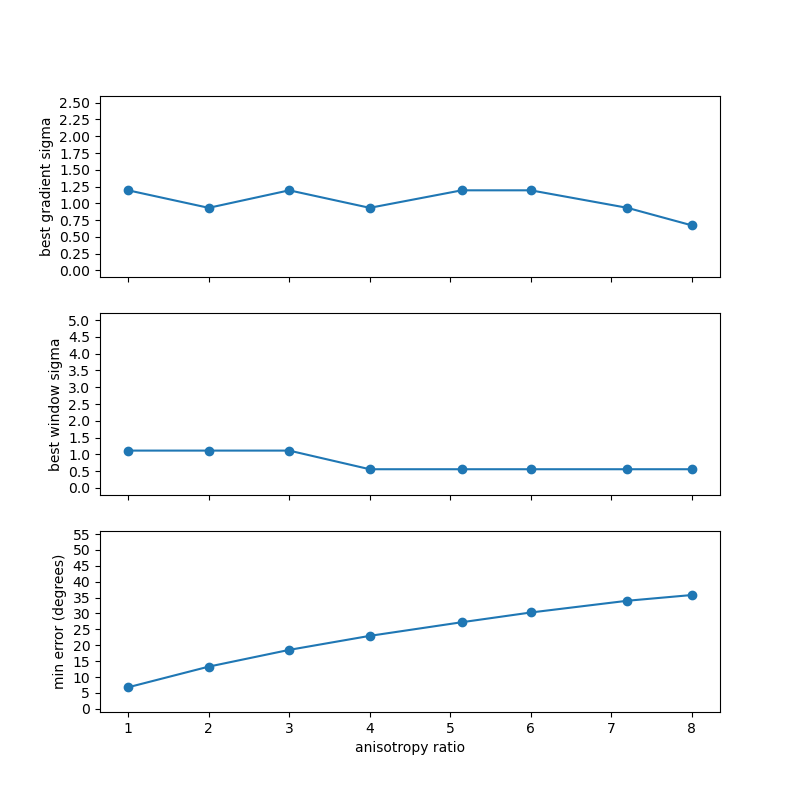

In [28]:
# get the sigmas at argmin of the error over the anisotropy axis
best_idx = np.empty((len(AI), 2))
for i in range(len(AI)):
    best_idx[i] = np.array(np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1]))

# plot the best sigma 1 and best sigma 2 versus the anisotropy ratio
fig, axs = plt.subplots(3, figsize=(8,8), sharex=True)
axs[0].plot(AI, derivative_sigmas[best_idx[:,0].astype(int)], marker='o')
axs[0].set_ylim(-0.1,2.6)
axs[0].set_yticks(np.arange(0.0,2.75,0.25))
axs[1].plot(AI, tensor_sigmas[best_idx[:,1].astype(int)], marker='o')
axs[1].set_ylim(-0.2,5.2)
axs[1].set_yticks(np.arange(0.0,5.5,0.5))
axs[0].set_ylabel('best gradient sigma')
axs[1].set_ylabel('best window sigma')
axs[2].plot(AI, errors_min, marker='o')
axs[2].set_ylim(-1,56)
axs[2].set_yticks(np.arange(0,60,5))
axs[2].set_ylabel('min error (degrees)')
axs[2].set_xlabel('anisotropy ratio')

## How does delta angle affect error?

Text(0, 0.5, 'count')

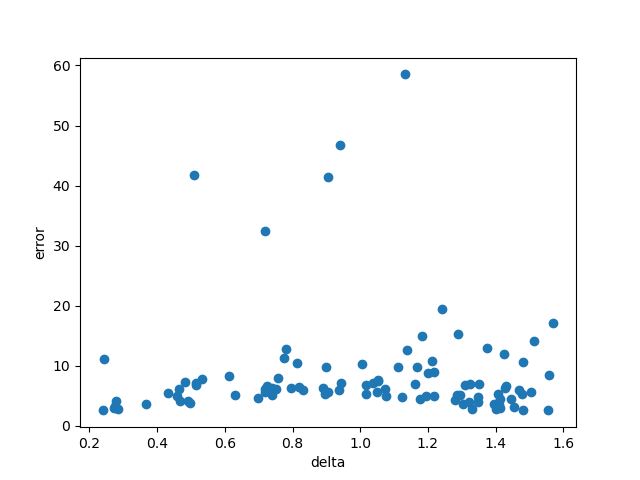

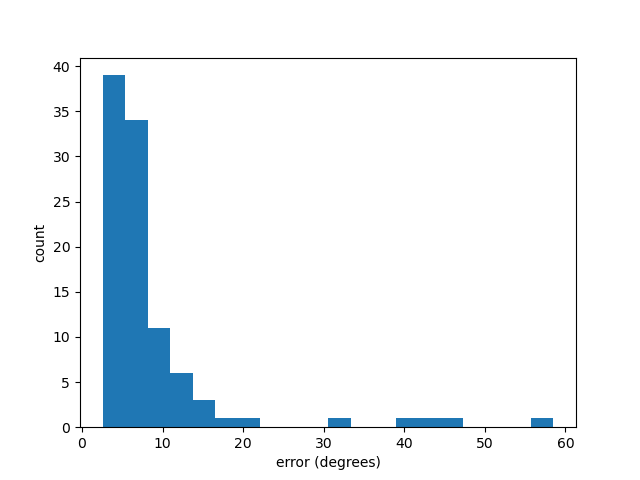

In [29]:
df = errors_df.query(f'derivative_sigma=={derivative_sigmas[4]} and tensor_sigma=={tensor_sigmas[2]} and AI==2.0 and period==10.0')

errors = df['error']
angles = df['angles']
delta = np.empty(len(angles))
mean = np.empty((len(angles), 2))
for i,a in enumerate(angles):
    u = np.array([np.sin(a[0][0])*np.sin(a[0][1]), np.sin(a[0][0])*np.cos(a[0][1]), np.cos(a[0][0])])
    v = np.array([np.sin(a[1][0])*np.sin(a[1][1]), np.sin(a[1][0])*np.cos(a[1][1]), np.cos(a[1][0])])
    dp = np.dot(u,v)
    delta[i] = np.arccos(np.abs(dp))
    sign = np.sign(dp)
    m = np.mean((sign*u,v), axis=0)
    m = m / np.linalg.norm(m)
    mean[i] = np.array([np.arccos(m[2]), np.arctan2(m[0], m[1])])

# scatter plot of errors by delta
plt.figure()
plt.scatter(delta, errors)
plt.xlabel('delta')
plt.ylabel('error')

# histogram of errors
plt.figure()
plt.hist(errors, bins=20)
plt.xlabel('error (degrees)')
plt.ylabel('count')



In [ ]:
print(df.iloc[np.argmax(df['error'])]['angles'])
print(df.iloc[np.argmax(df['error'])])
print(derivative_sigmas[4])
print(tensor_sigmas[2])



# Pipeline Figures

# first we generate a phantom with specified line orienations, period, and anisotropy  

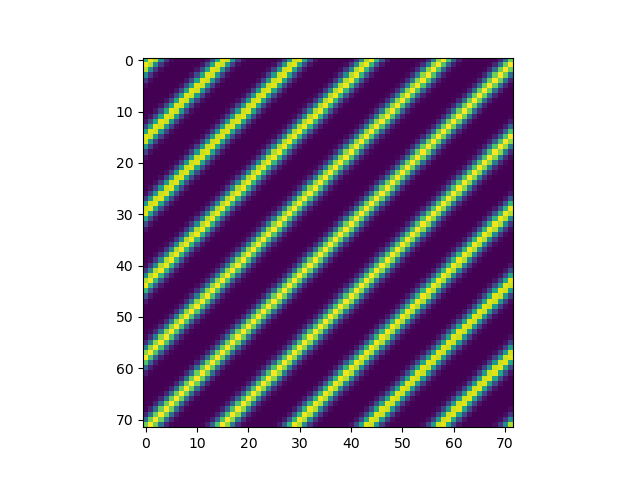

In [15]:
# in 2D
n = (72, 72)
d = (1.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
angles = np.array([3*np.pi/4])
img = sta_validate.make_phantom(x, angles)

plt.figure()
plt.imshow(img)

In [52]:
errors_df['angles'].iloc[0].shape


(2, 2)

[[0.87785638 0.39537273]
 [2.779481   1.58000096]]


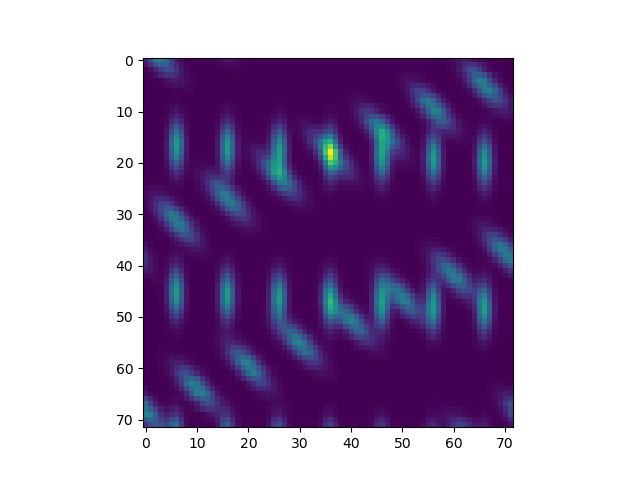

In [18]:
# in 3D
n = (36, 72, 72)
d = (2.0, 1.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
# true_thetas = np.array([np.pi/4, 3*np.pi/4])
true_thetas = errors_df['angles'].iloc[0]
print(true_thetas)
img = sta_validate.make_phantom(x, true_thetas)

plt.figure()
plt.imshow(img[:,:,36])

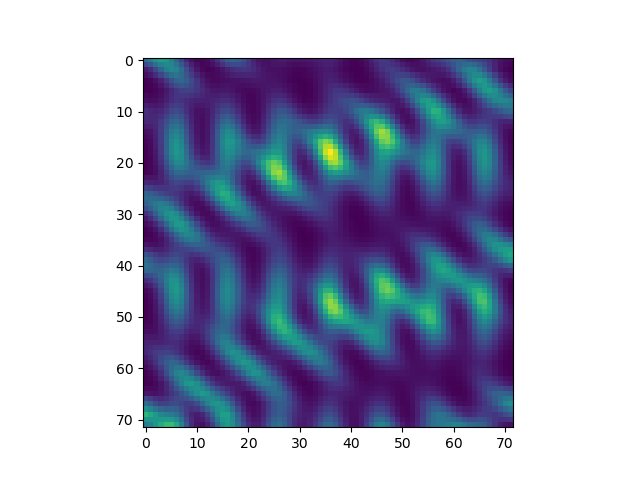

In [19]:
blur_factor = np.sqrt(d[0]**2 - 1.0)
new_image = gaussian_filter(img, sigma=[0.0, blur_factor, blur_factor])

plt.figure()
plt.imshow(new_image[:,:,36])

In [ ]:
# visualize with volume plot
Z,Y,X = np.mgrid[0:n[0]:1,0:n[1]:1,0:n[2]:1]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=img.flatten(),
    isomin=0.04,
    isomax=0.23,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=8, # needs to be a large number for good volume rendering
    ))
fig.update_layout(
    autosize=True,
    width=800,
    height=800,)
fig.show()
# py.iplot(fig, filename='volume_rendering')


## Next compute angles from structure tensors

In [20]:
S = histology.structure_tensor(img, derivative_sigma=0.75, tensor_sigma=5.0, dI=d, masked=False)
angles = histology.angles(S, cartesian=True)
plt.figure()
plt.imshow(angles[:,36,:,0])#, cmap='hsv')
plt.colorbar()

TypeError: structure_tensor() got an unexpected keyword argument 'dI'

In [21]:
angles_ = angles.reshape((-1,angles.shape[-1]))

true_thetas_ = np.array([np.sin(true_thetas[0])*np.sin(true_thetas[1]),
                                np.sin(true_thetas[0])*np.cos(true_thetas[1]),
                                np.cos(true_thetas[0])
                                ])
skm = apsym_kmeans.APSymKMeans(n_clusters=1)
skm.fit(angles_)
mu_ = skm.cluster_centers_
# convert mu_ from cartesian to spherical coordinates
mu = np.array([np.arccos(mu_[0][2]), np.arctan2(mu_[0][0], mu_[0][1])])
diff = np.arccos(np.abs(mu_.dot(true_thetas_))) * 180/np.pi

print(mu)
print(true_thetas)

IndexError: tuple index out of range

In [56]:
print(diff)

[[74.2427792  34.22509656]]
